In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time, timedelta
import calendar as c         # c is the module
c.setfirstweekday(c.SUNDAY)  # first day Sunday America not Monday Euro
cc = c.Calendar()            # cc is the an instantiation of the class Calendar; class Calendar inside module c

from dateutil.relativedelta import *
from dateutil.rrule import *
from dateutil.parser import *
from dateutil import rrule

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='darkgrid')

import copy

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read in the data

In [2]:
df = pd.read_csv('../data/df_2.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])    

#### Add a 'summation bit' to make collective summing easy.

In [4]:
df['summation_bit'] = 1

### Check if first day of the month yields anything

##### Heard a WalMart exec tell of the first of the month super-surge (  after a slow drip drop slide beginning around the 3rd week ).  Supposedly attributed to people getting fresh paychecks, private pension checks, and gov't program checks -- social security the biggest, unemployment ins., welfare assistance ---  after money getting tight as the previous month progressed.   

##### Perhaps people get desperate for cash as the month goes on and get tapped out,  and get a big relief when replenished.

##### Perhaps he meant the first week as opposed to first of month.   Because social security does not arrive exactly on the first,  and other disbursements may not be exactly the 1st either.  People may also wait a day or two for whatever reasons too.

### Check some scenerios

In [5]:
def first_of_month(m):
    return int(m.day == 1)

In [6]:
df['first_of_month'] = df['date'].apply(first_of_month)

In [7]:
df['first_of_month'].value_counts(normalize= True)

0    0.960056
1    0.039944
Name: first_of_month, dtype: float64

##### Calculate a  measure of influence the 1st has over what otherwise could have been expected

In [8]:
y_for_plotting = df['first_of_month'].value_counts(normalize= True)[1]

In [9]:
y_for_plotting / (12.0/365)

1.2149490500418034

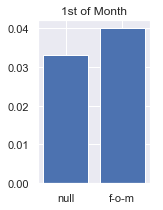

In [10]:
fig = plt.figure(figsize= (2, 3))
ax1 = fig.add_subplot(1,1,1)
plt.bar(np.array(['null', 'f-o-m']), np.array([12.0/365, y_for_plotting]))
plt.title('1st of Month')
plt.savefig('../assets/uno_of_month.png')

#### The 1st day of month crime difference is 21% higher than null case;  maybe it's something,  so check more 


#### Try capturing weeks leading up to the first of month,  and the first and second weeks afterward

In [11]:
'''
For each crime event (aka, df row)....
    1) find out what month the event belongs
    2) get the 1st of that month
    3) calculate forward from the 1st exactly one week
    4) see if that event falls within that timeframe
    5) if it does, tag/flag that event as having fallen in the first week of the month
    6) rinse and repeat the 1.9 million+ rows
'''

'\nFor each crime event (aka, df row)....\n    1) find out what month the event belongs\n    2) get the 1st of that month\n    3) calculate forward from the 1st exactly one week\n    4) see if that event falls within that timeframe\n    5) if it does, tag/flag that event as having fallen in the first week of the month\n    6) rinse and repeat the 1.9 million+ rows\n'

In [12]:
def calc_first_from_first(row):
    event_date             = row['date']
    start_of_current_month = pd.to_datetime(date(event_date.year, event_date.month, 1))
    window_top             = None
    window_bottom          = start_of_current_month + relativedelta(weeks=+1)
    return int(event_date < window_bottom)

df['first_week_from_first'] = df.apply(calc_first_from_first, axis= 1)

In [13]:
'''
For each crime event (aka, df row)....
    1) find out what month the event belongs
    2) get the 1st of that month
    3) calculate forward from the 1st exactly one week
    4) calculate forward from the 1st exactly two weeks
    5) see if that event falls in the window between those 2 timeframes
    6) if it does, tag/flag that event as having fallen in the second week of the month
    7) rinse and repeat the 1.9 million+ rows
'''

'\nFor each crime event (aka, df row)....\n    1) find out what month the event belongs\n    2) get the 1st of that month\n    3) calculate forward from the 1st exactly one week\n    4) calculate forward from the 1st exactly two weeks\n    5) see if that event falls in the window between those 2 timeframes\n    6) if it does, tag/flag that event as having fallen in the second week of the month\n    7) rinse and repeat the 1.9 million+ rows\n'

In [14]:
def calc_second_from_first(row):
    event_date             = row['date']
    start_of_current_month = pd.to_datetime(date(event_date.year, event_date.month, 1))
    window_top             = start_of_current_month + relativedelta(weeks=+1)
    window_bottom          = start_of_current_month + relativedelta(weeks=+2)
    return int((event_date >= window_top) & (event_date < window_bottom))

df['second_week_from_first'] = df.apply(calc_second_from_first, axis= 1)

In [15]:
'''
For each crime event (aka, df row)....
    1) find out what month the event belongs
    2) get the 1st of that month
    3) calculate forward exactly one month, then calculate backward exactly one week
    4) see if that event falls in the window of the new 1st of the next month and the week prior to the new 1st
    5) if it does, tag/flag that event as having fallen in the last week of the month
    6) rinse and repeat the 1.9 million+ rows
'''

'\nFor each crime event (aka, df row)....\n    1) find out what month the event belongs\n    2) get the 1st of that month\n    3) calculate forward exactly one month, then calculate backward exactly one week\n    4) see if that event falls in the window of the new 1st of the next month and the week prior to the new 1st\n    5) if it does, tag/flag that event as having fallen in the last week of the month\n    6) rinse and repeat the 1.9 million+ rows\n'

In [16]:
def calc_last_from_end(row):
    event_date             = row['date']
    start_of_current_month = pd.to_datetime(date(event_date.year, event_date.month, 1))
    window_top             = start_of_current_month + relativedelta(months=+1) - relativedelta(weeks=+1)
    window_bottom          = None
    return int(event_date >= window_top)

df['last_week_from_end'] = df.apply(calc_last_from_end, axis= 1)

In [17]:
# get the knack?   add a month, subtract from it a week, subtract from it two weeks,  check if in the 'window'

In [18]:
def calc_second_to_last_from_end(row):
    event_date             = row['date']
    start_of_current_month = pd.to_datetime(date(event_date.year, event_date.month, 1))
    window_bottom          = start_of_current_month + relativedelta(months=+1) - relativedelta(weeks=+1)
    window_top             = start_of_current_month + relativedelta(months=+1)  - relativedelta(weeks=+2)
    return int((event_date >= window_top) & (event_date < window_bottom))


df['second_to last_week_from_end'] = df.apply(calc_second_to_last_from_end, axis= 1)

#### To get an apples to apples comparison,  the following is done:

##### The number of weeks in a real year is 52,  while getting week 1 and 2 after the front of a given month and then week 1 and 2 from the back of the first day of next upcoming month implies 4 weeks per month times 12 months gives 48 weeks.   To get comparables,  get the null case of overall crimes PER WEEK.    Then calculate how many months there were calculated in the dataset,  note that each month contains 1 of each of the 4 different week frames.

In [19]:
df['month'] = pd.to_datetime(df['date']) 

In [20]:
df['year_month'] = df['date'].dt.to_period('M')

In [21]:
df['year_month'].unique()

<PeriodArray>
['2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11']
Length: 85, dtype: period[M]

##### The dataset started and ended on the middle Novembers;  the back end weeks got a bonus from the head of the dataset while the front end weeks got a bonus from the tail of the dataset, so essentially cancelling out all considered.   Note that the front and back end Novembers both got counted in the PeriodArray above, when only one should given the middle of the month start and ends.   So, PeriodArray is in overcount by 1 month, so given length of 85 is a true length of 84 months.

In [22]:
first_week_from_first_average = df['first_week_from_first'].sum() / 84.0
first_week_from_first_average

5365.678571428572

In [23]:
second_week_from_first_average = df['second_week_from_first'].sum() / 84.0
second_week_from_first_average

5148.75

In [24]:
second_week_from_end_average = df['second_to last_week_from_end'].sum() / 84.0
second_week_from_end_average

5263.071428571428

In [25]:
last_week_from_end_average = df['last_week_from_end'].sum() / 84.0
last_week_from_end_average

5176.023809523809

##### Get the number of weeks involved in dataset and calculate average crime per week

In [26]:
start_date = parse(str(pd.to_datetime(df.head(1)['date'].values[0])))
end_date   = parse(str(pd.to_datetime(df.tail(1)['date'].values[0])))

def weeks_between(start_date, end_date):
    weeks = rrule.rrule(rrule.WEEKLY, dtstart= start_date, until= end_date)
    return weeks.count()
dataset_weeks = weeks_between(start_date, end_date)
dataset_weeks

366

In [27]:
df['summation_bit'].sum()

1918909

In [28]:
overall_weekly_crime = df['summation_bit'].sum() / dataset_weeks
overall_weekly_crime

5242.920765027322

In [29]:
w_1     = (first_week_from_first_average / overall_weekly_crime) - 1
w_2     = (second_week_from_first_average / overall_weekly_crime) -1
w_2_end = (second_week_from_end_average / overall_weekly_crime) -1
w_1_end = (last_week_from_end_average / overall_weekly_crime) -1

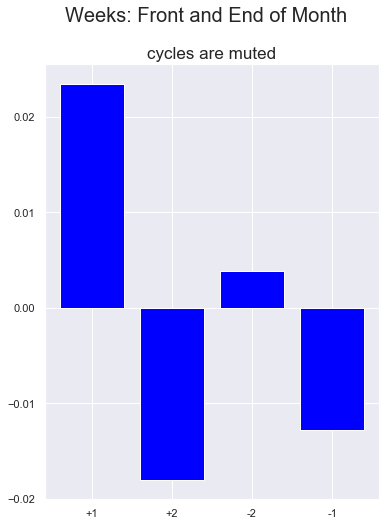

<Figure size 432x288 with 0 Axes>

In [30]:
x_values = ['+1', '+2', '-2', '-1' ]
y_values = [w_1, w_2, w_2_end, w_1_end]


fig = plt.figure(figsize= (6, 8))
ax = fig.add_subplot(1,1,1)
plt.bar(x_values, y_values, color= 'blue')
plt.suptitle('Weeks: Front and End of Month', fontsize= 20)
ax.set_title('cycles are muted', fontsize= 17)

plt.savefig('../assets/week_of_month_differences.png')

## There is a week-of cyclic factor in crime rates, yet the percentages are relatively small.

#### Mid-month uptick suggests paycheck cycle, but its a stretch.   Things go a BIT nuttier when people are a little more flush,  but big policy changes or big takeaways here really are thin.

## The very first day of month is perhaps the takeaway,  as it did have a 21% increase over the null.   A one day hit wonder followed with a cycle that's much much more muted.

## pick up workflow in next notebook

In [31]:
df.to_csv('../data/df_3.csv', index= False)